# *Spatially Varying Nanophotonic Neural Networks* 

This codebase is organized in two parts:

**In Part 1**: We perform inference on experimental measurements captured by our SVN3 prototype lab setup (see illustration below), and reproduce the Figure 3b (Confusion Matrices) and Figure 4 (Visualization of experimental classification results on CIFAR-10) from the main manuscript.
<details>
  <summary>Click to expand the SVN3 prototype setup illustration</summary>
  
  <img src="figures/system_setup.png" alt="drawing" width="1024"/>
  
</details>

**In Part 2**: We reproduce the Table S2 (copied below for convenience) in our Supplementary Document. Specifically, we evaluate the CIFAR-10 blind test accuracy, the number of multiply–accumulate (MAC) operations, the number of parameters (# of PARAMS) for the optical and electronic parts of different models. The evaluated models range from the basic naive small-kernel spatially-invariant (SKSI) design to the proposed large-kernel spatially-varying (LKSV) convolutional layer.

<details>
  <summary>Click to expand Table S2 (ablation experiments for the proposed design variant)</summary>

| Model      | ACC        | MAC (Optical ↑) | MAC (Electronic ↓) | TIME (Optical ↑) | TIME (Electronic ↓) | # of PARAMS (Optical ↑) | # of PARAMS (Electronic ↓) |
|-----------|-----------|---------------|------------------|----------------|-------------------|------------------------|---------------------------|
| AlexNet   | 72.64 %   | -             | 174.85 M         | -              | 70.58 us          | -                      | 57.03 M                   |
|           |           | -             | 100 %            | -              | 100 %             | -                      | 100 %                     |
| SKSI      | 65.45 %   | 243.20 K      | 125.30 K         | 0.41 us        | 2.64 us           | 0.25 K                 | 2.03 K                    |
|           |           | 66.00 %       | 34.00 %          | 13.56 %        | 86.44 %           | 10.94 %                | 89.06 %                   |
| LKSI*     | 67.13 %   | 5.78 M        | 125.30 K         | 3.54 us        | 2.64 us           | 5.65 K                 | 2.03 K                    |
|           |           | 97.88 %       | 2.12 %           | 57.25 %        | 42.75 %           | 73.52 %                | 26.48 %                   |
| LKSI      | 71.64 %   | 5.78 M        | 125.30 K         | 3.54 us        | 2.64 us           | 5.65 K                 | 2.03 K                    |
|           |           | 97.88 %       | 2.12 %           | 57.25 %        | 42.75 %           | 73.52 %                | 26.48 %                   |
| SKSV*     | 57.69 %   | 1.41 M        | 125.30 K         | 27.72 us       | 2.64 us           | 6.52 K                 | 2.03 K                    |
|           |           | 91.83 %       | 8.17 %           | 91.30 %        | 8.70 %            | 76.21 %                | 23.79 %                   |
| SKSV      | 71.14 %   | 1.41 M        | 125.30 K         | 27.72 us       | 2.64 us           | 6.52 K                 | 2.03 K                    |
|           |           | 91.83 %       | 8.17 %           | 91.30 %        | 8.70 %            | 76.21 %                | 23.79 %                   |
| LKSV      | **73.80** % | 34.59 M     | 125.30 K         | 302.66 us      | 2.64 us           | 38.92 K                | 2.03 K                    |
|           |           | **99.64** %   | **0.36** %       | **99.14** %    | **0.86** %        | **95.03** %            | **4.97** %                |

*Note*: The labels SK/LK refer to small and large kernel respectively; SI/SV indicate spatially invariant and spatially varying respectively. * denotes large kernel and/or spatially varying convolutional layer learned without low-dimensional reparameterization. ACC denotes here the blind testing accuracy on the CIFAR-10 dataset. The result of AlexNet is also listed as a reference.
</details>

## Prerequisite: Setup Environment

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import models
from flops_profiler.profiler import get_model_profile, _flops_to_string, _params_to_string
from utils.utils import gen_model_param_config, get_model, get_config, get_dataset_labels, dataset_vis_prob, data_augmentation, visualize_cm, ftr2arr, visualize_cls_prob

# Enable LaTeX rendering globally
pgf_with_latex = {
    "text.usetex": True,            # use LaTeX to write all text    
    "font.family": 'sans-serif',
    "font.sans-serif": ["Arial"],
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,           # Ignore Matplotlibrc        
    "pgf.preamble": "\n".join([        
        r"\usepackage{color}",            # load additional packages
        r"\usepackage{xcolor}",   
        r"\definecolor{ForestGreen}{HTML}{009B55}"
        r"\definecolor{Orange}{HTML}{F58137}"
    ])
}
plt.rcParams.update(pgf_with_latex)

## Part 1: SVN3 Inference Using Experimental Data

In Part 1, we will load a finetuned electronic backend to perform inference directly on experimental measurements captured by our SVN3 prototype. Then we'll use precomputed prediction labels to generate confusion matrices as well as classification (probability) results on random CIFAR-10 samples.

- Load finetuned electronic backend 

In [2]:
work_path = './experiments/cifar10/svn3'
config = get_config(os.path.join(work_path, 'config.yaml'))
model = get_model(config)
checkpoint = torch.load(os.path.join(work_path, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"], strict=True)  # torch > 1.9.0
model.eval()

OENet(
  (opto_stem): CorrectLayer(
    (correct_vars): ParameterDict(
        (s1): Parameter containing: [torch.FloatTensor of size 1x25x1x1]
        (s2): Parameter containing: [torch.FloatTensor of size 1x25x1x1]
    )
  )
  (first_norm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (local_pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (stages): ModuleList(
    (0): Identity()
    (1): Identity()
  )
  (transitions): ModuleList(
    (0): Sequential(
      (dw): Conv2d(25, 25, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=25, bias=False)
      (pw): Conv2d(25, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlinear): ReLU()
    )
  )
  (norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (head): Linear(in_features=50, out_featu

- Load and visualze the experimental capture 

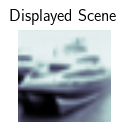

In [3]:
%matplotlib inline
# CIFAR-10 class names
cifar_10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

exp_data = torch.load('./data/clsdata/cifar10/exp_measure_1.pt')

img = exp_data['img']  # original image, would not be feed into the electronic backend
ftrs_p = exp_data['ftrs_p']
ftrs_n = exp_data['ftrs_n']
label = exp_data['label']


# let's show the original scene first.
plt.figure(figsize=(1.2, 1.2));
plt.imshow(img, cmap='bone', vmin=0, vmax=1, interpolation='bilinear');
plt.title('Displayed Scene');
plt.axis('off');
plt.show()

The corresponding experimental captured optical feature maps:

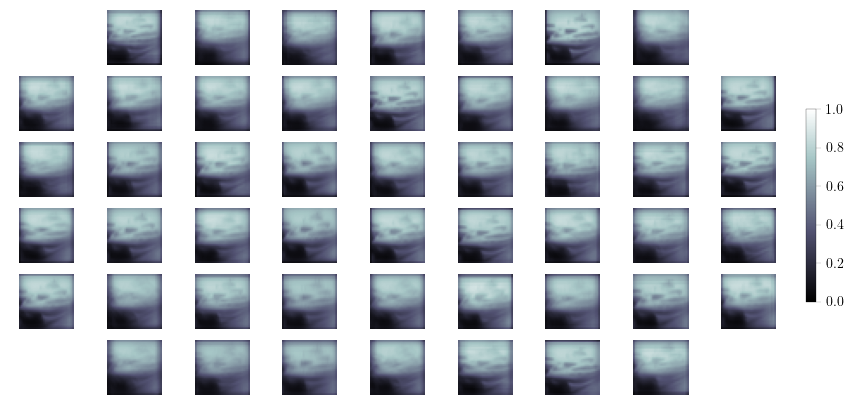

In [4]:
ftr2arr(ftrs_p, ftrs_n, img_size=32, chip_pattern_type='6x9', draw_figure=True, show=True, cmap='bone');

- Process the optical features by the simple two-layer electronic backend

Predicted probabilities for each class: tensor([8.6233e-03, 1.0177e-01, 7.5046e-06, 9.0808e-05, 2.1076e-05, 3.4100e-07,
        3.2886e-05, 4.5543e-06, 8.8766e-01, 1.7942e-03])
Predicted label: ship; Ground true label: ship


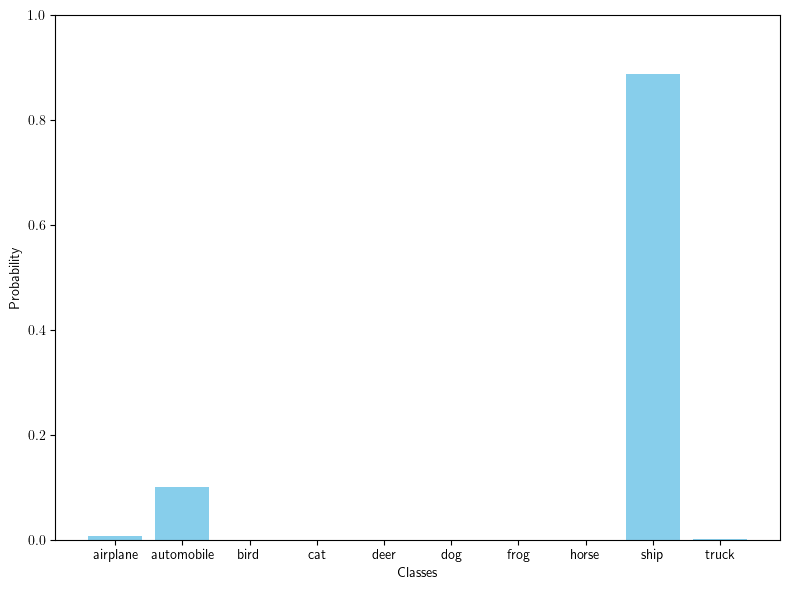

In [5]:
with torch.no_grad():
    predict_prob = nn.functional.softmax(model((ftrs_p[None], ftrs_n[None])).squeeze(), dim=-1)
    predict_label = predict_prob.max(0)[1]

print(f'Predicted probabilities for each class: {predict_prob}')
print(f'Predicted label: {cifar_10_classes[predict_label]}; Ground true label: {cifar_10_classes[label]}')

visualize_cls_prob(predict_prob, class_names=cifar_10_classes)

Great! Our SVN3 gives the accurate prediction, i.e., ship in this scene. It also uncovers the tight relation among vehicles like airplane and automobile. 

Next we load the original CIFAR-10 testset, which will be used for illustration purpose (the dataset will be automatically downloaded into "./data/clsdata/cifar10")

In [6]:
# load testset
work_path = './experiments/cifar10/svn3'
config = get_config(os.path.join(work_path, 'config.yaml'))
transform_test = transforms.Compose(data_augmentation(config, is_train=False, grayscale=True))
testset = torchvision.datasets.CIFAR10(root='./data/clsdata/cifar10', train=False, download=False, transform=transform_test)

By comparing the precomputed labels from experiments/simulation with ground truth, we estimate the confusion matrices as follows:

- Confusion Matrix (Experimental Results)

Text(0.5, 1.0, 'Experimental Results - Accuracy: 72.76%')

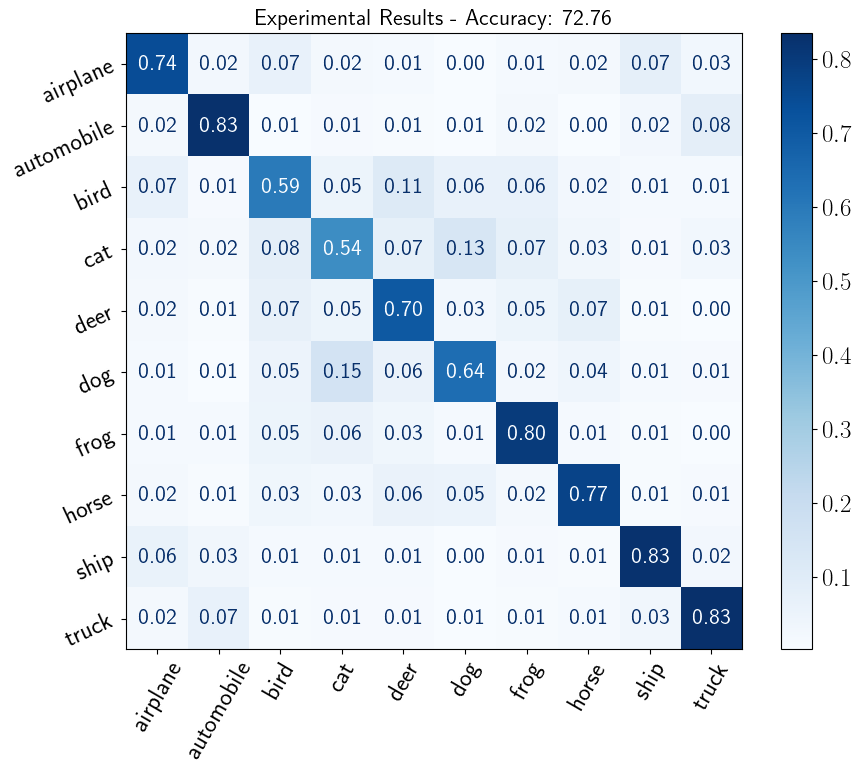

In [7]:
%matplotlib inline
labels = get_dataset_labels(testset)

# load predicted label for experimental captured data
predicts_prob = np.load(os.path.join('./experiments/cifar10/svn3', 'predicts.npy'))
predicts = np.argmax(predicts_prob, axis=1)
acc = np.equal(predicts, labels).sum() / len(labels)

ax = visualize_cm(labels, predicts, testset.classes)
plt.title(f'Experimental Results - Accuracy: {acc:.2%}', fontdict={'fontsize': 16})

- Confusion Matrix (Simulation Results)

Text(0.5, 1.0, 'Simulation Results - Accuracy: 73.79%')

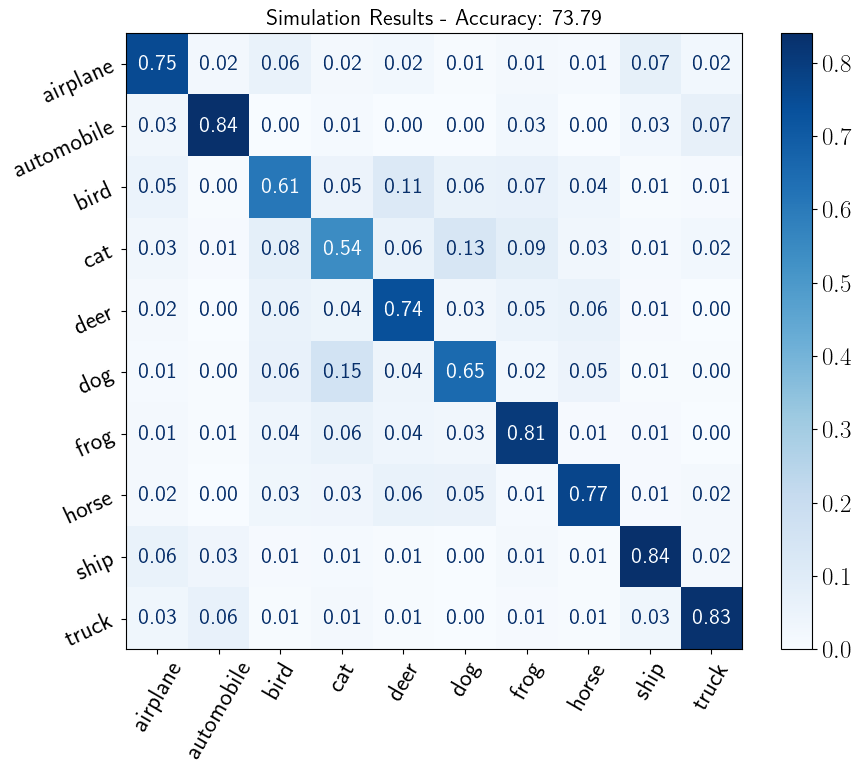

In [8]:
%matplotlib inline
labels = get_dataset_labels(testset)

# load predicted label for experimental captured data
predicts_prob = np.load(os.path.join('./experiments/cifar10/ablation/oenet_o3x7sv_t1', 'predicts.npy'))
predicts = np.argmax(predicts_prob, axis=1)
acc = np.equal(predicts, labels).sum() / len(labels)

ax = visualize_cm(labels, predicts, testset.classes)
plt.title(f'Simulation Results - Accuracy: {acc:.2%}', fontdict={'fontsize': 16})

Confusion matrices displayed above reveal the similar recognition behavior of the SVN3 in real experiment and simulation.

To further understand the performance of the SVN3, we show the top-2 predicted labels (associated with probabilities) on random CIFAR-10 samples, which reproduces the Figure 4 of the main paper. 

- Classification visual results on CIFAR-10

In [9]:
predicts_prob = np.load(os.path.join(work_path, 'predicts.npy'))
predicts = np.argmax(predicts_prob, axis=1)

np.random.seed(2024)
mpl.use("pgf")
dataset_vis_prob(testset, predicts_prob=predicts_prob, savepath='./figures/cifar10_vis_res.png')

The above generated classification visual results are saved in './figures/cifar10_vis_res.png'. 
You can adjust the random seed to generate results on different random samples (10 randomly selected images for each class, 100 random images in total)
<details>
  <summary>Click to expand the experimental CIFAR-10 classification visual results</summary>
    
  <img src="figures/cifar10_vis_res.png" alt="drawing" width="1024"/>
  
</details>

## Part 2: Ablation Study of LKSV Design

In Part2, we evaluate the classification accuracy of a set of optoelectronic network designs on CIFAR-10 testset. The overall architecture is shown below, which is composed of an optical convolutional stem and a tiny electronic backend. All designs share the same electronic backend architecture while utilizing different variants of optical convolutional stem.

<details>
  <summary>Click to expand the network design illustration</summary>
    
  <img src="figures/network_design.png" alt="drawing" width="1024"/>
  
</details>



- Small-kernel spatially-invariant (SKSI) optical convolution

In [10]:
!python -u test_cifar10.py --work-path ./experiments/cifar10/ablation/oenet_o3x1_t1 --no-log

Files already downloaded and verified
[2023-12-29 19:51:22,667] - [test_cifar10.py line: 40] :  === Model Evaluation on CIFAR-10 testset ===
[2023-12-29 19:51:31,720] - [test_cifar10.py line: 60] :    == test acc: 65.450%


- Naive large-kernel spatially-invariant (LKSI*) optical convolution without large-kernel factorization

In [11]:
!python -u test_cifar10.py --work-path ./experiments/cifar10/ablation/oenet_o15x1_t1 --no-log

Files already downloaded and verified
[2023-12-29 19:51:35,942] - [test_cifar10.py line: 40] :  === Model Evaluation on CIFAR-10 testset ===
[2023-12-29 19:51:39,675] - [test_cifar10.py line: 60] :    == test acc: 67.130%


- Large-kernel spatially-invariant (LKSI) optical convolution with large-kernel factorization

In [12]:
!python -u test_cifar10.py --work-path ./experiments/cifar10/ablation/oenet_o3x7_t1 --no-log

Files already downloaded and verified
[2023-12-29 19:51:43,509] - [test_cifar10.py line: 40] :  === Model Evaluation on CIFAR-10 testset ===
[2023-12-29 19:51:47,371] - [test_cifar10.py line: 60] :    == test acc: 71.640%


- Naive small-kernel spatially-varying (SKSV*) optical convolution without low-rank spatially-varying reparameterization

In [13]:
!python -u test_cifar10.py --work-path ./experiments/cifar10/ablation/oenet_o3x1sv0_t1 --no-log

Files already downloaded and verified
[2023-12-29 19:51:51,174] - [test_cifar10.py line: 40] :  === Model Evaluation on CIFAR-10 testset ===
[2023-12-29 19:51:54,989] - [test_cifar10.py line: 60] :    == test acc: 57.690%


- Small-kernel spatially-varying (SKSV) optical convolution with low-rank spatially-varying reparameterization

In [14]:
!python -u test_cifar10.py --work-path ./experiments/cifar10/ablation/oenet_o3x1sv_t1 --no-log

Files already downloaded and verified
[2023-12-29 19:51:58,796] - [test_cifar10.py line: 40] :  === Model Evaluation on CIFAR-10 testset ===
[2023-12-29 19:52:02,662] - [test_cifar10.py line: 60] :    == test acc: 71.140%


- Large-kernel spatially-varying (LKSV) optical convolution with low-dimensional reparameterization

In [15]:
!python -u test_cifar10.py --work-path ./experiments/cifar10/ablation/oenet_o3x7sv_t1 --no-log

Files already downloaded and verified
[2023-12-29 19:52:06,498] - [test_cifar10.py line: 40] :  === Model Evaluation on CIFAR-10 testset ===
[2023-12-29 19:52:10,946] - [test_cifar10.py line: 60] :    == test acc: 73.790%


Next, we assess two key metrics i.e., the number of multiply–accumulate (MAC) operations and the number of parameters (# of PARAMS) for the optical and electronic parts of different models. Runtime numbers that depend on the computing arch (e.g., CPU and GPU devices) would not be reported here. We will use a python package namely [flops-profiler](https://github.com/cli99/flops-profiler) to profile models in fine-grained manner.

- AlexNet for (grayscale) CIFAR-10 image classification

In [16]:
input_shape = (1, 1, 32, 32)
model = models.AlexNet_32()
model.eval()

with torch.no_grad():
    flops, macs, params = get_model_profile(model=model, # model
                                    input_shape=input_shape, # input shape or input to the input_constructor                                
                                    print_profile=True, # prints the model graph with the measured profile attached to each module                                
                                    module_depth=-1, # depth into the nested modules with -1 being the inner most modules
                                    top_modules=1, # the number of top modules to print aggregated profile
                                    warm_up=0, # the number of warm-ups before measuring the time of each module
                                    as_string=False, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
                                    ignore_modules=None,
                                    )


-------------------------- Flops Profiler --------------------------
Profile on Device: cpu
Profile Summary at step 0:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per device:                                            57.03 M 
params of model = params per device * mp_size:                57.03 M 
fwd MACs per device:                                          174.77 MMACs
fwd flops per device:                                         349.69 M
fwd flops of model = fwd flops per device * mp_size:          349.69 M
fwd latency:                                                  157.65 ms
fwd FLOPS per device = fwd flops per devi

*Note we compute MACs by dividing number of floating-point operations (flops) by 2:*

In [17]:
print(_flops_to_string(flops / 2))
print(_params_to_string(params))

174.85 MFLOPS
57.03 M


The above results confirm the AlexNet model has 174.85 MMACs and 57.03 M parameter for grayscale CIFAR-10 classification.

Then, we profile different variants of optoelectronic networks. The optical and electronic parts are reported separately. 

In [18]:
model_type = 'LKSV' # please freely adjust the model_type from [SKSI, LKSI, SKSV, LKSV] to see the profile of different models
input_shape = (1, 1, 32, 32)
model = models.OENet(10, **gen_model_param_config(model_type))
model.eval()

flops, macs, params = get_model_profile(model=model, # model
                                input_shape=input_shape, # input shape or input to the input_constructor                                
                                print_profile=True, # prints the model graph with the measured profile attached to each module                                
                                module_depth=-1, # depth into the nested modules with -1 being the inner most modules
                                top_modules=1, # the number of top modules to print aggregated profile
                                warm_up=0, # the number of warm-ups before measuring the time of each module
                                as_string=False, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
                                ignore_modules=None,                                
                                )


-------------------------- Flops Profiler --------------------------
Profile on Device: cpu
Profile Summary at step 0:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per device:                                            40.95 k 
params of model = params per device * mp_size:                40.95 k 
fwd MACs per device:                                          34.65 MMACs
fwd flops per device:                                         69.42 M 
fwd flops of model = fwd flops per device * mp_size:          69.42 M 
fwd latency:                                                  4.01 ms 
fwd FLOPS per device = fwd flops per device

From the "Detailed Profile" above, we can see the optical MACs is 69.17/2 = 34.585 M, and the electronic MACs = (25.6 + 25.6 + 195.2 + 3.2 + 1) / 2 = 125.30 K  
The percentage of the optical compute is:
>'params%': '95.03%', 'flops%': '99.64%'